# Table of Contents
* [I. Introduction](#1)


* [II. Loading Data/Packages](#2)
    

* [III. Model Training](#3)

    * [A. XGBoost](#3a)
        * [1. Helper Functions](#3a1)
        * [2. Tuning Hyperparameters using Cross Validation](#3a2)
            * [a. Finding the Optimal Learning Rate](#3a2a)
            * [b. Finding the Optimal # of Trees](#3a2b)
        * [3. Testing Candidate Models](#3a3)
        
    * [B. Random Forest Regression](#3b)
        * [1. Helper Functions](#3b1)
        * [2. Tuning Hyperparameter `mtry`](#3b2)
        * [3. Testing Candidate Models](#3b3)
        * [4. Additional Analysis](#3b4)
        
    * [C. Bagging (Regression)](#3c)
        * [1. Tuning Hyperparameter `num_trees`](#3c1)
        * [2. Testing Candidate Models](#3c2)
        * [3. Additional Analysis](#3c3)

    * [D. Linear Regression](#3d)
        * [1. Defining Models/Cross Validation](#3d1)
        * [2. Testing Candidate Models](#3d2)
    
    * [E. Regularized Linear Regression (Ridge)](#3e)
        * [1. Defining Models/Cross Validation](#3e1)
        * [2. Testing Candidate Models](#3e2)
   
   
* [IV. Conclusion](#4)
    

***

# I. Introduction<a class="anchor" id="1"></a>


The following walks through a step by step model-building/model-selection process on provided training and test datasets **wildfires_train.csv** and **wildfires_test.csv**. I built various candidate models using tree-based methods and linear regression on **wildfires_train.csv**. Candidate models were evaluated on a provided test set **wildfires_test.csv**.

This analysis was taken from my lab assignment from *STAT 301-3: Data Science III* at Northwestern University. 

### Dataset Overview

The wildfires dataset describes 500 wildfires that started within a large national park. **wildfires_train.csv** includes 350 of these instances, and **wildfires_test.csv** includes 150 of these instances. The origin of each fire is shown below in red.

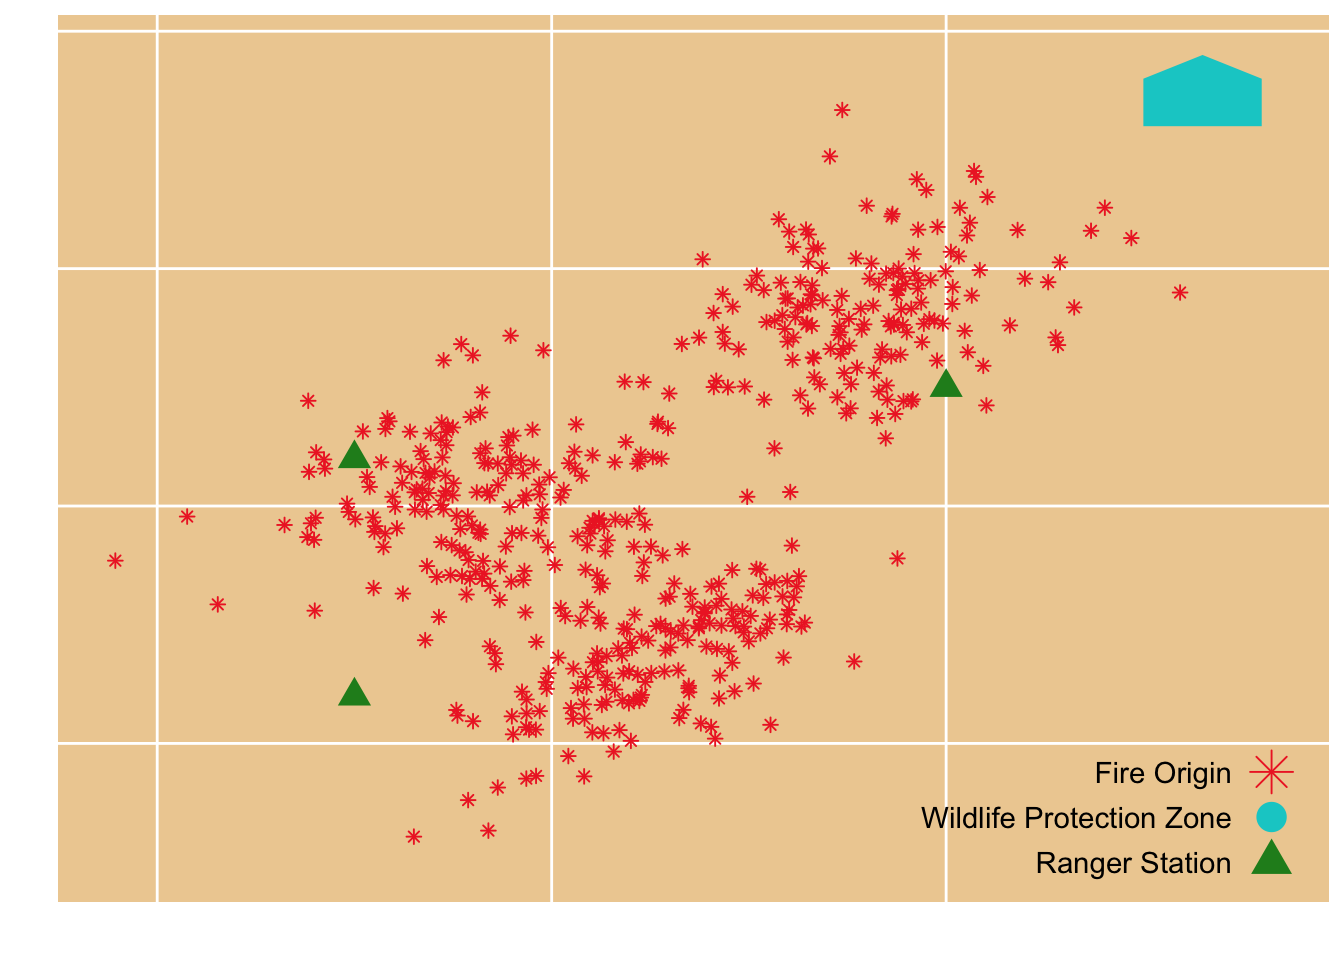

A number of factors may affect how large a fire becomes. For example, if it starts near a ranger station (green triangles on the map) during a time when it is manned, fires may be less likely to spread.

The dataset contains observations on 350 fires started in a large national park. For each fire, the data contain 15 variables, in addition to two target variables (`burned` and `wlf`). These variables are the following.

- `x`, and `y`: the (x, y) coordinates of where the fire started.
- `temp`: air temperature when the fire started
- `humidity`: air humidity when the fire started
- `windspd`: wind speed when the fire started
- `winddir`: wind direction when the fire started
- `rain`: rainfall in the week preceding the fire
- `days`: number of days since the last fire
- `vulnerable`: amount of vulnerable (unburned) foliage near the fire
- `other`: indicates if another fire is ongoing when the fire starts
- `ranger`: indicates if the fire started near a ranger station, and that ranger station was manned. Note that even if a fire started near a ranger station, that station may not have been manned at the time.
- `pre1950`: indicates if the fire occured before 1950, which it became more common to use planes and helicopters to fight forest fires.
- `heli`: indicates if a helicopter was available to fight the fire
- `resources`: composite score for the resources available to fight the fire, including manpower and available air support
- `traffic`: indicates the level of foot traffic in the national park when the fire started


**Target Variables**

- `burned`: indicates number of hectares burned by the fire
- `wlf`: binary variable indicating if fire reached the wildlife protection zone

### Regression Task 

The total area burned by a wildfire is of great concern to government planners. This is captured by the variable `burned` in the wildfires dataset, which is a continuous variable. Various models were trained to predict `burned` using other variables in the data, including:
- Boosting
- Bagging
- Random Forest
- Linear Regression
- Regularized Linear Regression (Ridge)

Mean squared error (MSE) was used to evaluate the models on the test set.

***

# II. Loading Data/Packages <a class="anchor" id="2"></a>

The datasets will be loaded in Tibble format.

In [4]:
# Suppressing warnings
options(warn=-1)

# Loading package(s)

# Data wrangling/processing
library(modelr)
library(tidyverse)
library(janitor)
library(rsample)
library(knitr)
library(onehot)

# For random forests
library(ranger)
library(vip)
library(pdp)

# For boosted models
library(xgboost)

# For Ridge Regression
library(glmnet)
library(glmnetUtils)

# Loading train data 
wildfires_train <- read.csv("data/wildfires_train.csv") %>%
  dplyr::as_tibble() %>%
  clean_names() %>% 
  mutate_if(is_character, factor)

# Loading test data 
wildfires_test <- read.csv("data/wildfires_test.csv") %>%
  as_tibble() %>%
  clean_names() %>% 
  mutate_if(is_character, factor)

# Setting seed 
set.seed(4)

# III. Model Training<a class="anchor" id="3"></a>

## A. XGBoost <a class="anchor" id="3a"></a>

I will be tuning two parameters for boosting: the learning rate `eta` and the number of trees to build `nrounds`. Boosting sequentially builds trees, meaning each tree depends on the one previous, unlike bagging, which takes independent bootstrap samples of the dataset to generate multiple independent trees. Initially, XGBoost makes an initial prediction that is the average of all observations, and upon construction of a tree that predicts a new residual, the initial prediction is "updated" with the new residual value, which should move in the direction towards the value of the actual observation. The learning rate controls how quickly the predictions "improve." A small learning rate means the "movement to the right direction" of the prediction is small after each tree. Therefore, this would probably need a larger number of trees for a more accurate model. In other words, a smaller `eta` and larger `nrounds` lowers bias but increases variance (risk of overfitting), while a larger `eta` and smaller `nrounds` increases bias but decreases variance (risk of underfitting). The goal is to find the balance between bias and variance to choose the correct parameters. To do this, **cross validation** can be used.

### 1. Helper Functions<a class="anchor" id="3a1"></a>

- `xgb_matrix()` converts our tibble dataframe into a matrix 
- `xg_error()` gets MSE/misclass rate of the test set

In [6]:
xgb_matrix <- function(dat, outcome, exclude_vars){
  # Sanitize input: check that data has factors, not characters
  dat_types <- dat %>% map_chr(class)
  outcome_type <- class(dat[[outcome]])
  if("chr" %in% dat_types){
    # If we need to re-code, leave that outside of the function
    print("You must encode characters as factors.")
    return(NULL)
  } else {
    # If we're doing binary outcomes, they need to be 0-1
    if(outcome_type == "factor" & nlevels(dat[[outcome]]) == 2){
      tmp <- dat %>% select(outcome) %>% onehot::onehot() %>% predict(dat)  
      lab <- tmp[,1]
    } else {
      lab <- dat[[outcome]]
    }
    # Make our DMatrix
    mat <- dat %>% dplyr::select(-outcome, -all_of(exclude_vars)) %>% # encode on full boston df
      onehot::onehot() %>% # use onehot to encode variables
      predict(dat) # get OHE matrix
    return(xgb.DMatrix(data = mat, 
                       label = lab))
  }
}

xg_error <- function(model, test_mat, metric = "mse"){
  # Get predictions and actual values
  preds = predict(model, test_mat)
  vals = getinfo(test_mat, "label")
  if(metric == "mse"){
    # Compute MSE if that's what we need
    err <- mean((preds - vals)^2)
  } else if(metric == "misclass") {
    # Otherwise, get the misclass rate
    err <- mean(preds != vals)
  }
  return(err)
}

### 2. Tuning Hyperparameters using Cross Validation<a class="anchor" id="3a2"></a>

#### a. Finding the optimal learning rate $\eta$<a class="anchor" id="3a2a"></a>

I am doing cross validation on the provided model building data. Here we try 20 different values of eta's from -10 to -.1 (logarithmically scaled), and fitting all of them for all 10 folds of cross validation. We will use `nrounds = 500`, a typical value, but will be tuning this later. We also calculate the MSE for all fitted models, on both the train split and the test split.

Running 10-fold cross validation on various $\eta$ values

In [7]:
# Fitting xgboost
wildfires_xg_reg_cv_eta <- wildfires_train %>%
  crossv_kfold(10, id = "folds") %>% # creates train/validation sets named train, test
  crossing(eta = 10^seq(-10, -.1, length.out = 20)) %>%
  mutate(
    train = map(train, as_tibble),
    test = map(test, as_tibble), # validation dataset for each iteration of cv
    train_mat = map(train, xgb_matrix, outcome = "burned", exclude_vars = "wlf"), 
    test_mat = map(test, xgb_matrix, outcome = "burned", exclude_vars = "wlf"),
    xg_model = map2(.x = train_mat, .y = eta,
                    .f = function(x, y) xgb.train(params = list(eta = y, # set learning rate
                                                                objective = "reg:squarederror"), # calculating mse 
                                                  data = x, 
                                                  nrounds = 500)),
    xg_train_mse = map2_dbl(xg_model, train_mat, xg_error, metric = "mse"), # train MSE
    xg_test_mse = map2_dbl(xg_model, test_mat, xg_error, metric = "mse") # test MSE
  )
      

Calculating mean train/test (CV) MSE's for different $\eta$:

In [72]:
wildfires_xg_reg_eta_meanmse <- wildfires_xg_reg_cv_eta %>% 
  group_by(eta) %>%
  summarise(mean_train_mse = mean(xg_train_mse),
            mean_val_mse = mean(xg_test_mse)) %>%
  arrange(mean_val_mse)
head(wildfires_xg_reg_eta_meanmse)

eta,mean_train_mse,mean_val_mse
<dbl>,<dbl>,<dbl>
0.072093272,1.281264e-02,8072.470
0.021719114,7.888223e+01,8205.229
0.239302573,1.111619e-06,8590.134
0.006543189,2.583411e+03,9550.777
0.794328235,3.136969e-07,14186.616
0.001971228,8.731855e+04,91341.134


Plotting learning rate vs. mean MSE 

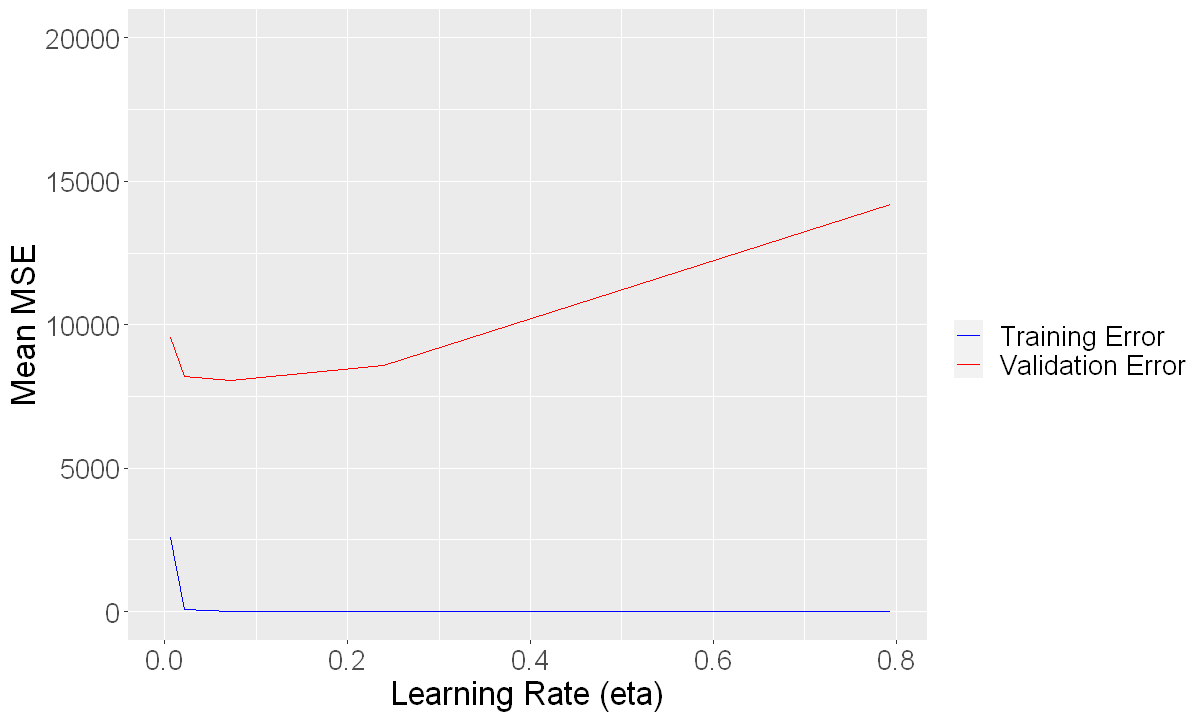

In [96]:
options(repr.plot.width=10, repr.plot.height=6)

ggplot(wildfires_xg_reg_eta_meanmse) + 
  geom_line(aes(eta, mean_train_mse, color = "Training Error")) +
  geom_line(aes(eta, mean_val_mse, color = "Validation Error")) +
  scale_color_manual("", values = c("blue", "red")) + 
  labs(x = "Learning Rate (eta)", y = "Mean MSE") +
  ylim(0, 20000) +
  theme(text=element_text(size=20))

The top three models with the lowest cross validation test errors will be stored as candidate models for later. 

In [22]:
# Storing best 3 etas
(candidate_etas <- wildfires_xg_reg_eta_meanmse %>%
    arrange(mean_test_mse) %>%
    head(3) %>%
    select(eta))

eta
<dbl>
0.07209327
0.02171911
0.23930257


#### b. Finding the optimal number of trees (`nround`)<a class="anchor" id="3a2b"></a>

The lowest $\eta$ value was 0.07209327. I will again perform 10-fold CV on the training set on different values of `nround`, or the number of decision trees to make. Increasing the number of trees in the ensemble will introduce more bias and decrease variance. Too high of a number can lead to underfitting. Upon trial and error, I found 20~400 (20 `nrounds` values) a reasonable range. I use the following 20 values for `nround` and will identify the ones that produce the lowest MSE given $\eta$ = 0.07209327.

In [66]:
wildfires_xg_reg_cv_nrounds <- wildfires_train %>%
  crossv_kfold(10, id = "folds") %>%
  crossing(nrounds = 10*seq(2, 40, length.out = 20)) %>% #testing 20 different nrounds
  mutate(
    train = map(train, as_tibble), # converting to tibble
    test = map(test, as_tibble), # converting to tibble
    train_mat = map(train, xgb_matrix, outcome = "burned", exclude_vars = "wlf"), 
    test_mat = map(test, xgb_matrix, outcome = "burned", exclude_vars = "wlf"),
    xg_model = map2(.x = train_mat, .y = nrounds,
                    .f = function(x, y) xgb.train(params = list(eta = 0.07209327, # set as best learning rate from above
                                                                objective = "reg:squarederror"), # calculating mse 
                                                  data = x, 
                                                  nrounds = y)),
    xg_train_mse = map2_dbl(xg_model, train_mat, xg_error, metric = "mse"), # train MSE
    xg_test_mse = map2_dbl(xg_model, test_mat, xg_error, metric = "mse") # test MSE
  )


Calculating Mean MSE across each fold per `nround` value

In [77]:
# Calculating mean train/validation MSE's for different nrounds
(wildfires_xg_reg_nrounds_meanmse <- wildfires_xg_reg_cv_nrounds %>%
  group_by(nrounds) %>%
  summarise(mean_train_mse = mean(xg_train_mse),
            mean_val_mse = mean(xg_test_mse)) %>%
  arrange(mean_val_mse)) 



nrounds,mean_train_mse,mean_val_mse
<dbl>,<dbl>,<dbl>
100,2.728507e+02,8164.205
80,4.340074e+02,8172.436
120,1.767730e+02,8207.421
140,9.997316e+01,8233.987
60,9.348504e+02,8253.820
160,5.602629e+01,8258.148
200,1.935860e+01,8262.821
180,3.248645e+01,8264.426
220,1.161009e+01,8275.274


It seems that ideal numbers are at the lower end of the range. Plotting this gives us this graph

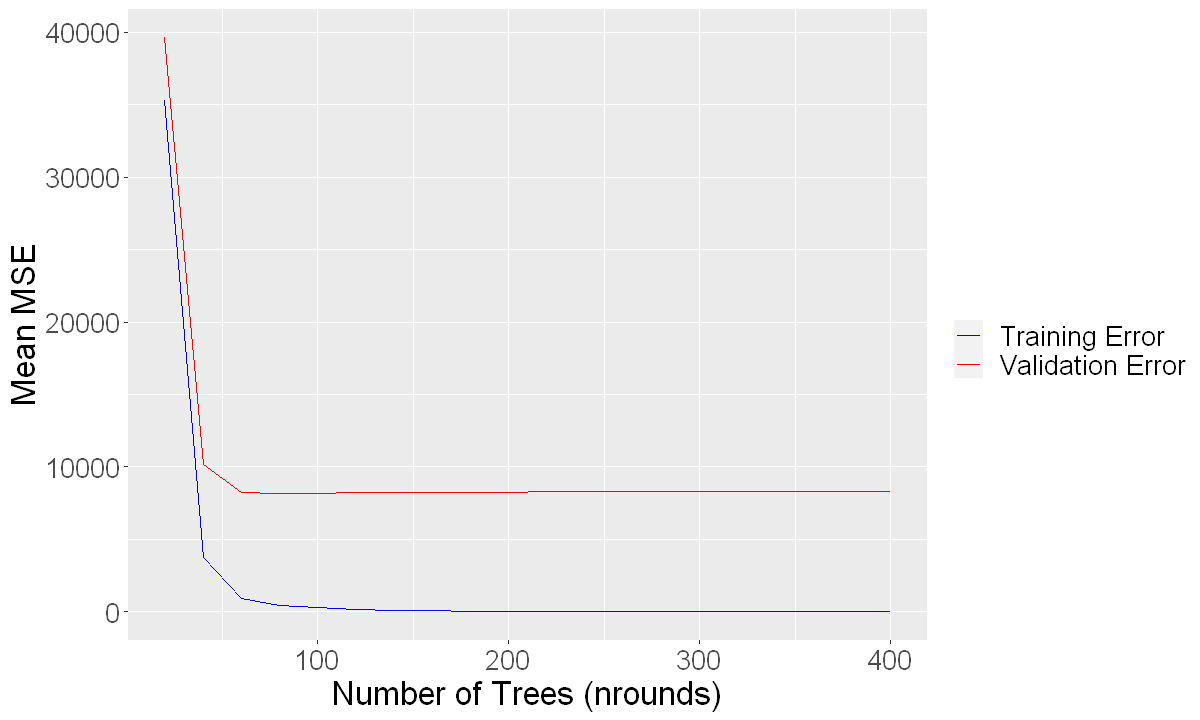

In [97]:
ggplot(wildfires_xg_reg_nrounds_meanmse) + 
  geom_line(aes(nrounds, mean_train_mse, color = "Training Error")) +
  geom_line(aes(nrounds, mean_val_mse, color = "Validation Error")) +
  scale_color_manual("", values = c("blue", "red")) + 
  labs(x = "Number of Trees (nrounds)", y = "Mean MSE") + 
  theme(text=element_text(size=20))

We can see that the test error stablizes around `nround` = 50~100. There seems to be no improvement in validation error after around 60-100 trees. Again, we store the best three candidates of `nround` for model selection.



In [71]:
(candidate_nrounds <- wildfires_xg_reg_nrounds_meanmse %>%
    arrange((mean_test_mse)) %>%
    head(3) %>%
    select(nrounds))

nrounds
<dbl>
100
80
120


### 3. Testing Candidate Models <a class="anchor" id="3a3"></a>

I have chosen 3 `eta` and 3 `nround` values. In total, I use models of all combinations of those values (9 models) to produce predictions on the test set and calculate the final test errors. 


In [82]:
set.seed(4)
(wildfires_xg_reg <- tibble(
  train = wildfires_train %>% list(),
  test = wildfires_test %>% list() # importing test data
  ) %>%
  crossing(eta = candidate_etas$eta) %>% # crossing by 3 etas
  crossing(nrounds = candidate_nrounds$nrounds) %>% # crossing by 3 nrounds
  mutate(
    train_mat = map(train, xgb_matrix, outcome = "burned", exclude_vars = "wlf"), # transforming to xgb matrix
    test_mat = map(test, xgb_matrix, outcome = "burned", exclude_vars = "wlf"), # transforming to xgb matrix
    xg_model = pmap(.l = list(x = train_mat, y = eta, z = nrounds), # using pmap function
                    .f = function(x, y, z) xgb.train(params = list(eta = y, # set learning rate
                                                                   objective = "reg:squarederror"), # calculating mse
                                                     data = x, 
                                                     nrounds = z)),
    xg_train_mse = map2_dbl(xg_model, train_mat, xg_error, metric = "mse"), # train MSE
    xg_test_mse = map2_dbl(xg_model, test_mat, xg_error, metric = "mse") # test MSE
  ) %>% 
  arrange(xg_test_mse) %>% # arranging by test MSE
  select(eta, nrounds, xg_train_mse, xg_test_mse)) # selecting relevant columns

eta,nrounds,xg_train_mse,xg_test_mse
<dbl>,<dbl>,<dbl>,<dbl>
0.07209327,100,3.801281e+02,11264.50
0.07209327,120,2.460507e+02,11274.35
0.07209327,80,5.420193e+02,11373.16
0.23930257,80,5.514666e+00,11545.24
0.23930257,100,9.850205e-01,11569.39
0.23930257,120,1.551459e-01,11574.53
0.02171911,120,5.942563e+03,16111.99
0.02171911,100,1.121662e+04,21183.28
0.02171911,80,2.258061e+04,31982.26


From the results, it seems that learning rate is the more important determining tuning hyperparameter than `nrounds`, as the same `eta`s are placed similarly in the rankings. `eta = 0.07209327` seems to be the best one, and we can really probably any `nround` around the 280~320 range. We will just pick the best one from this result and store it to compare with models from Random Forest, Bagging, etc.

In [89]:
# Storing the best model
wildfires_reg_models <- wildfires_xg_reg %>%
  select(eta, nrounds, xg_test_mse) %>%
  head(1) %>%
  mutate(model_type = "XGBoost", tuning = "eta = 0.07209327, nrounds = 100") %>%
  rename(testMSE = xg_test_mse) %>%
  select(model_type, tuning, testMSE)

wildfires_reg_models

model_type,tuning,testMSE
<chr>,<chr>,<dbl>
XGBoost,"eta = 0.07209327, nrounds = 100",11264.5


***

## B. Random Forest Regression<a class="anchor" id="3b"></a>

For Random Forests, I used `mtry` as the only tuning parameter. I will use `num.trees` as a tuning parameter for Bagging. `mtry` tells us how many variables to use while splitting the nodes to consruct bootstrapped trees. We have 15 predictors to predict `burned` (we are excluding `wlf`), so I will fit models that use `mtry` from 1 to 15. First, we need some helper functions to calculate the MSE.

### 1. Helper Functions <a class="anchor" id="3b1"></a>

- `mse_ranger` calculates MSE of random forest/bagging predictions

In [90]:
mse_ranger <- function(model, test, outcome){
  # Check if test is a tibble
  if(!is_tibble(test)){
    test <- test %>% as_tibble()
  }
  # Make predictions
  preds <- predict(model, test)$predictions
  # Compute MSE
  mse <- mean((test[[outcome]] - preds)^2)
  return(mse)
}

### 2. Tuning Hyperparameter `mtry`<a class="anchor" id="3b2"></a>

We will fit the model and calculate the MSE using `mtry` from 1 to 15, again using 10-fold CV of the model building `wildfires_train` dataset. In addition to the test and validation MSE, we will also calculate OOB error rate. When constructing tree from bootstrapped samples, a given observation gets left out from about 1/3 of the trees. These observations are known as "out of bag." The out of bag observations, since they were not used in those specific 1/3 of the trees, they are run through those trees, and the prediction error for those observations are calculated as well. It's important data to compare, but `test_mse` still holds more weight in terms of determining accuracy of models.

In [91]:
set.seed(4)
wildfires_rf_reg_cv_mtry <- wildfires_train %>% 
  crossv_kfold(10, id = "folds") %>%
  crossing(mtry = 1:(ncol(wildfires_train) - 2)) %>% # tune different values of mtry (1-15)
  mutate(
    train = map(train, as_tibble), # change to tibbles
    test = map(test, as_tibble), # change to tibbles
    # Fit models for each value of mtry
    model = map2(.x = train, .y = mtry, 
                 .f = function(x, y) ranger(burned ~ . - wlf, 
                                            mtry = y, 
                                            data = x, 
                                            splitrule = "variance", 
                                            importance = "impurity")), 
    # Get training, test, and OOB error
    train_err = map2_dbl(model, train, mse_ranger, outcome = "burned"), # train MSE
    test_err = map2_dbl(model, test, mse_ranger, outcome = "burned"),  # test MSE
    oob_err = map_dbl(.x = model, 
                  .f = function(x) x[["prediction.error"]]) # out of bag error
  )

Calculating the mean of all error metrics across the folds, and their associated `mtry` values

In [92]:
(wildfires_rf_reg_mtry_meanerr <- wildfires_rf_reg_cv_mtry %>%
  group_by(mtry) %>%
  summarise(mean_train_err = mean(train_err),
            mean_val_err = mean(test_err),
            mean_oob_err = mean(oob_err)) %>%
  arrange(mean_val_err))

mtry,mean_train_err,mean_val_err,mean_oob_err
<int>,<dbl>,<dbl>,<dbl>
8,1274.777,7174.578,7313.800
9,1264.630,7188.468,7330.460
7,1304.898,7201.720,7278.137
6,1334.437,7226.775,7262.355
10,1265.948,7286.369,7376.955
11,1268.541,7315.415,7444.911
5,1379.945,7346.035,7375.482
12,1267.015,7376.089,7496.038
13,1273.069,7452.040,7568.487


It seems that using range of 6~10 features is ideal. Plotting these results

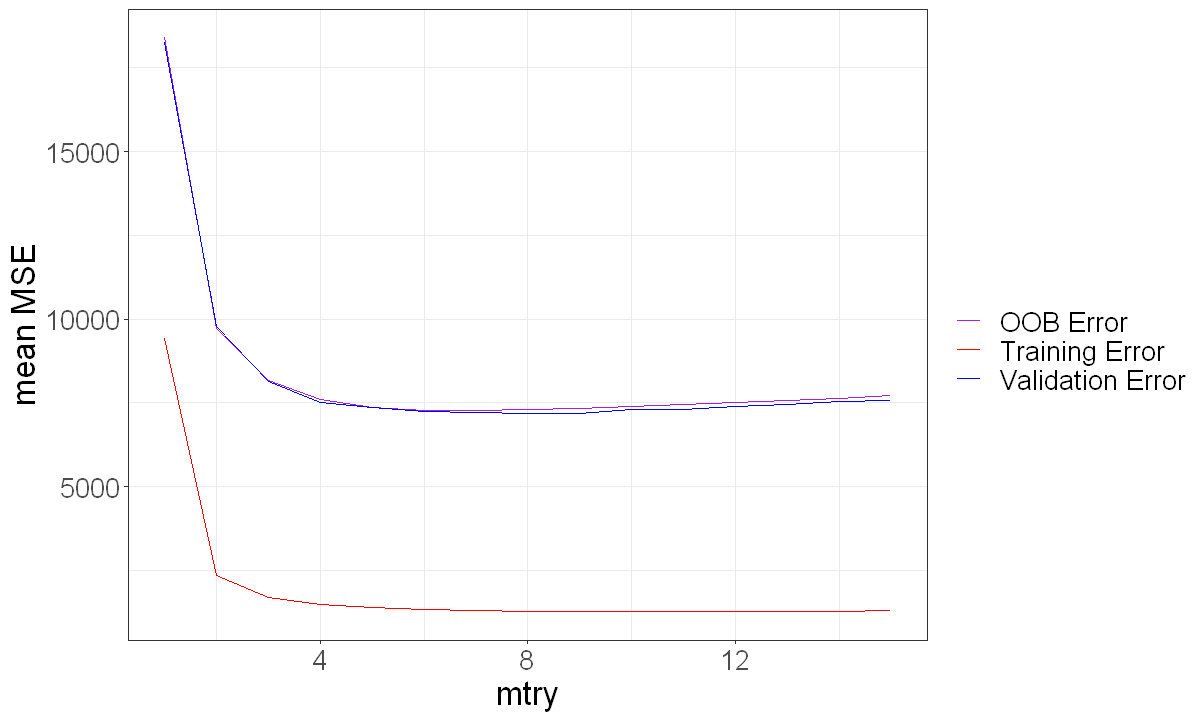

In [98]:
ggplot(wildfires_rf_reg_mtry_meanerr) + 
  geom_line(aes(mtry, mean_oob_err, color = "OOB Error")) +
  geom_line(aes(mtry, mean_train_err, color = "Training Error")) +
  geom_line(aes(mtry, mean_val_err, color = "Validation Error")) + 
  labs(x = "mtry", y = "mean MSE") + 
  scale_color_manual("", values = c("purple", "red", "blue")) + 
  theme_bw() + 
  theme(text=element_text(size=20))

The OOB and Test Error are pretty similar, while the training error is low as expected. The mean MSE seems to decline sharply from `mtry = 1`, hit the lowest between 4-8, and increase again very slowly. We will store the best 3 `mtry` values to fit the test data later.


In [101]:
candidate_mtry <- wildfires_rf_reg_mtry_meanerr %>%
    arrange(mean_val_err) %>%
    head(3) %>%
    select(mtry)
t(as.matrix(candidate_mtry))

mtry,8,9,7


### 3. Testing Candidate Models <a class="anchor" id="3b3"></a>

We just have 3 `mtry` values, so we have 3 models to fit. 

In [102]:
(wildfires_rf_reg <- tibble(
  train = wildfires_train %>% list(), # train data
  test = wildfires_test %>% list() # test data
  ) %>%
  crossing(mtry = candidate_mtry$mtry) %>% # crossing by 3 mtry values
  mutate(
    model = map2(.x = train, .y = mtry, 
                 .f = function(x, y) ranger(burned ~ . - wlf, 
                                            mtry = y, 
                                            data = x, 
                                            splitrule = "variance", 
                                            importance = "impurity")), # fitting models
    # Get training, test, and OOB error
    train_err = map2_dbl(model, train, mse_ranger, outcome = "burned"), 
    test_err = map2_dbl(model, test, mse_ranger, outcome = "burned"), 
    oob_err = map_dbl(.x = model, 
                      .f = function(x) x[["prediction.error"]])
  ) %>%
  arrange(test_err) %>% # arranging from lowest to highest test MSE 
  select(mtry, train_err, test_err, oob_err)) # selecting relevant

mtry,train_err,test_err,oob_err
<int>,<dbl>,<dbl>,<dbl>
8,1256.068,9459.360,7237.539
9,1249.722,9541.272,7232.789
7,1294.922,9778.933,7206.699


Storing the best performing model and its `mtry` value for comparison


In [103]:
(wildfires_reg_models <- wildfires_rf_reg %>%
  select(test_err) %>%
  head(1) %>%
  mutate(model_type = "Random Forest", tuning = "mtry = 8") %>%
  rename(testMSE = test_err) %>%
  select(model_type, tuning, testMSE) %>%
  rbind(wildfires_reg_models))

model_type,tuning,testMSE
<chr>,<chr>,<dbl>
Random Forest,mtry = 8,9459.36
XGBoost,"eta = 0.07209327, nrounds = 100",11264.50


### 4. Additional Analysis<a class="anchor" id="3b4"></a>

#### a. Feature Importance 

Because `mtry = 8` was selected as the best parameter, we will use this to fit the model again and look at variable importance.

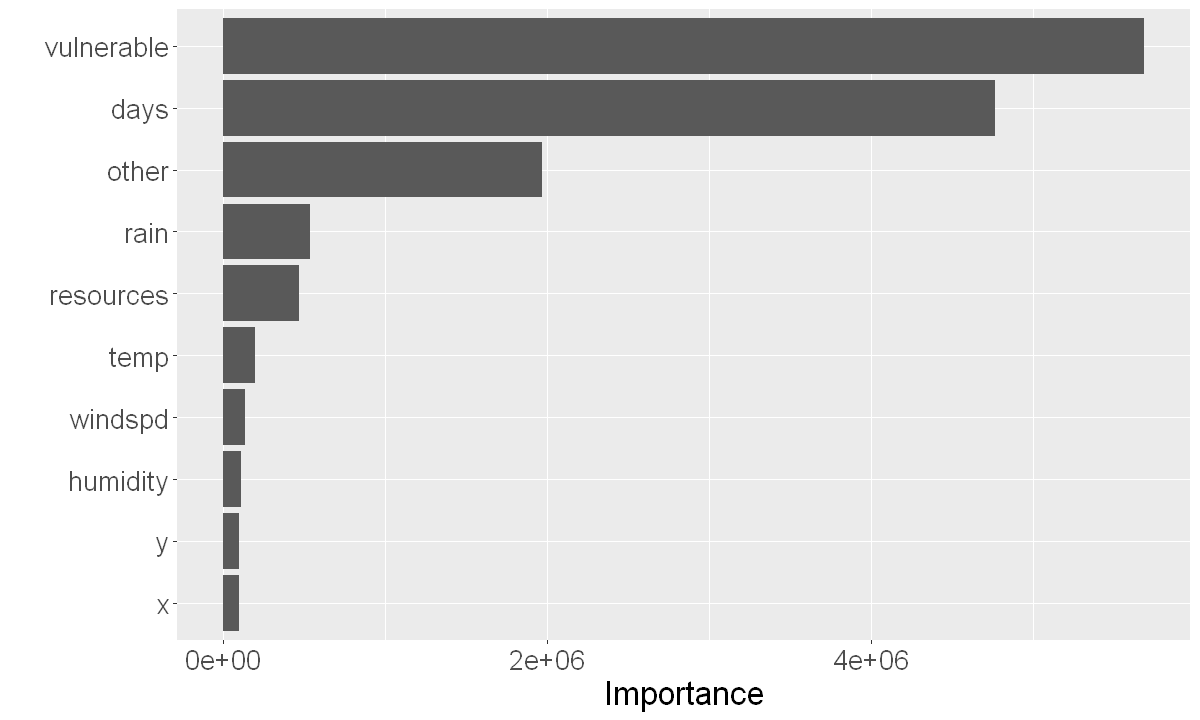

In [105]:
wildfires_rf_reg_mtry8 <- ranger(burned ~ . - wlf, 
                         data = wildfires_test, 
                         mtry = 8,
                         importance = "impurity", 
                         splitrule = "variance")
vip(wildfires_rf_reg_mtry8) +
  theme(text=element_text(size=20))


It seems that `vulnerable` or amount of vulnerable foliage in the area determined the most important factor in determining the area of wildfire, which makes sense. `days` or number of days since the last fire and `other` which indicates if there are other fires are ongoing were also important factors. This information is useful when narrowing down predictors for choosing linear regression models.

#### b. Partial Dependence 

To examine `vulnerable`, the most significant feature, and how it affects `burned`, I created a partial dependence plot 

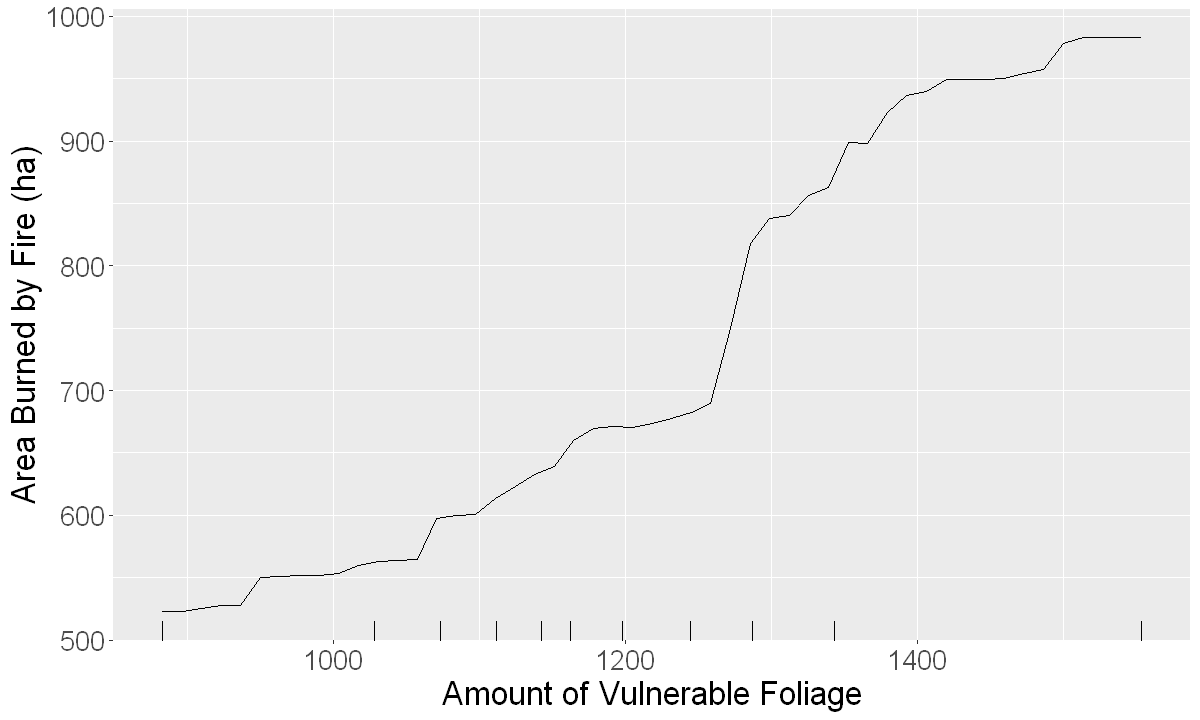

In [106]:
partial(wildfires_rf_reg_mtry8, 
        pred.var = "vulnerable",
        pred.data = wildfires_test,
        plot = TRUE,
        rug = TRUE,
        plot.engine = "ggplot2") + 
  labs(y = "Area Burned by Fire (ha)", x = "Amount of Vulnerable Foliage") + 
  theme(text=element_text(size=20))


This plot confirms a high direct correlation between `burned` (area burned by fire) and amount of vulnerable foilage in the area. A sharp increase is notable around 1300 which can serve as a certain benchmark for officials and conservationists. 

***

## C. Bagging (Regression)<a class="anchor" id="3c"></a>

Bagging is similar to Random Forest but there is no option to create trees with different samples of features (`mtry` is the maximum value, or 15, as there are 15 predictors). Instead of tuning `mtry`, we will tune the number of trees (`num.trees`). The hyperparameter is similar to XGBoost's `nround`. A higher number of trees results in lower bias, but more variance.

### 1. Tuning hyperparameter `num_trees`<a class="anchor" id="3c1"></a>

Fitting Bagging models with 20 different `num.trees` ranging from 100 to 2000 and performing cross validation

In [107]:
wildfires_bagging_reg_num.trees <- wildfires_train %>% 
  crossv_kfold(10, id = "folds") %>%
  crossing(num.trees = 100 * (1:20)) %>% # tune different values of num.trees
  mutate(
    train = map(train, as_tibble), # change to tibble
    test = map(test, as_tibble), # change to tibble
    # Fit models for each value of num.trees
    model = map2(.x = train, .y = num.trees, 
                 .f = function(x, y) ranger(burned ~ . - wlf, 
                                            mtry = 15, # Total number of predictors
                                            num.trees = y,
                                            data = x, 
                                            splitrule = "variance", 
                                            importance = "impurity")), 
    # Get training, test, and OOB error
    train_err = map2_dbl(model, train, mse_ranger, outcome = "burned"), 
    test_err = map2_dbl(model, test, mse_ranger, outcome = "burned"), 
    oob_err = map_dbl(.x = model, 
                      .f = function(x) x[["prediction.error"]])
  )

Averaging error statistics across different folds, we get this result


In [108]:
(wildfires_bagging_reg_num.trees_meanerr <- wildfires_bagging_reg_num.trees %>%
    group_by(num.trees) %>%
    summarise(mean_train_err = mean(train_err),
              mean_val_err = mean(test_err),
              mean_oob_err = mean(oob_err)) %>%
    arrange(mean_val_err))

num.trees,mean_train_err,mean_val_err,mean_oob_err
<dbl>,<dbl>,<dbl>,<dbl>
400,1290.020,7603.248,7684.815
1700,1280.848,7618.787,7631.508
700,1285.611,7623.658,7676.896
1800,1284.890,7628.596,7650.970
1600,1282.734,7644.070,7662.973
800,1286.176,7645.400,7682.454
1000,1283.347,7654.582,7652.949
1300,1279.186,7662.691,7648.859
1200,1289.669,7666.574,7644.562


The trend is a little hard to see and kind of all over the place so we can graph this.


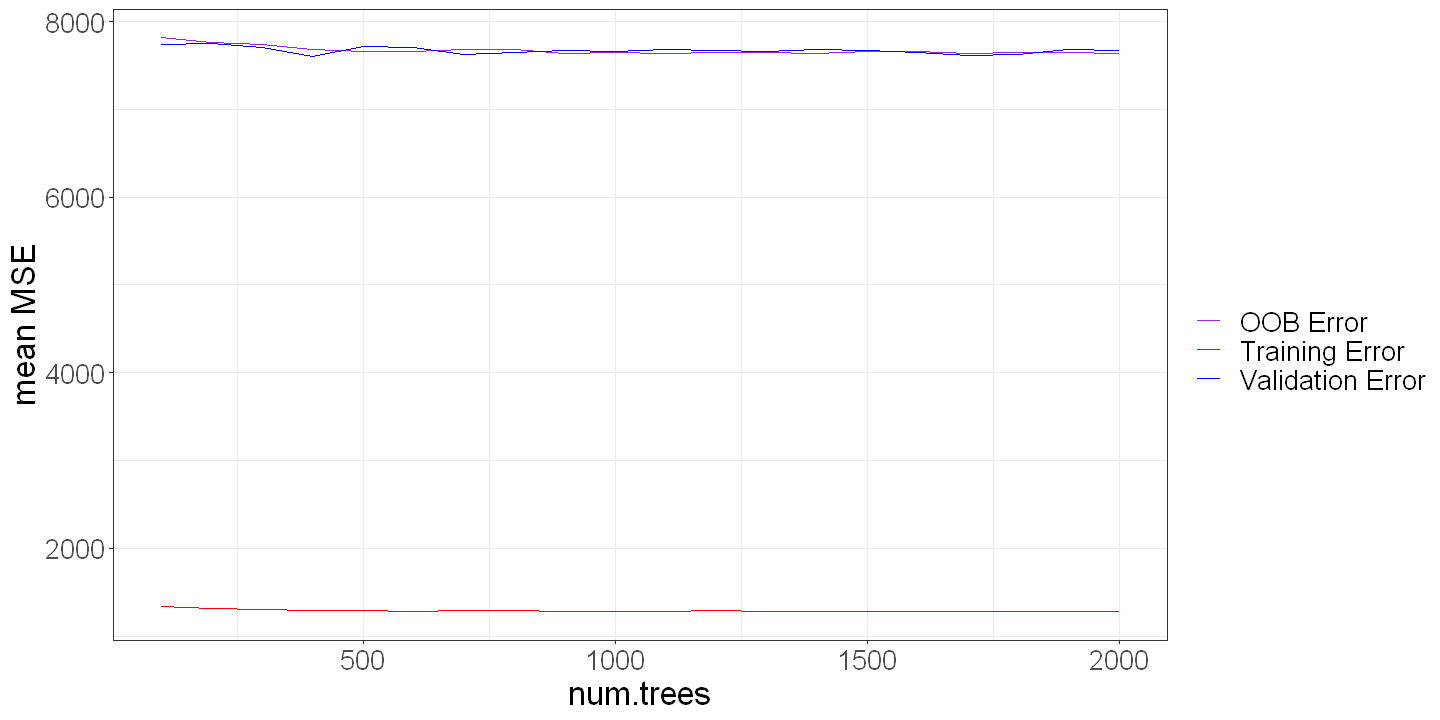

In [117]:
options(repr.plot.width=12, repr.plot.height=6)

(p <- ggplot(wildfires_bagging_reg_num.trees_meanerr) + 
  geom_line(aes(num.trees, mean_oob_err, color = "OOB Error")) +
  geom_line(aes(num.trees, mean_train_err, color = "Training Error")) +
  geom_line(aes(num.trees, mean_val_err, color = "Validation Error")) + 
  labs(x = "num.trees", y = "mean MSE") + 
  scale_color_manual("", values = c("purple", "red", "blue")) + 
  theme_bw() + 
  theme(text=element_text(size=20)))

Zooming in on the validation error and training error

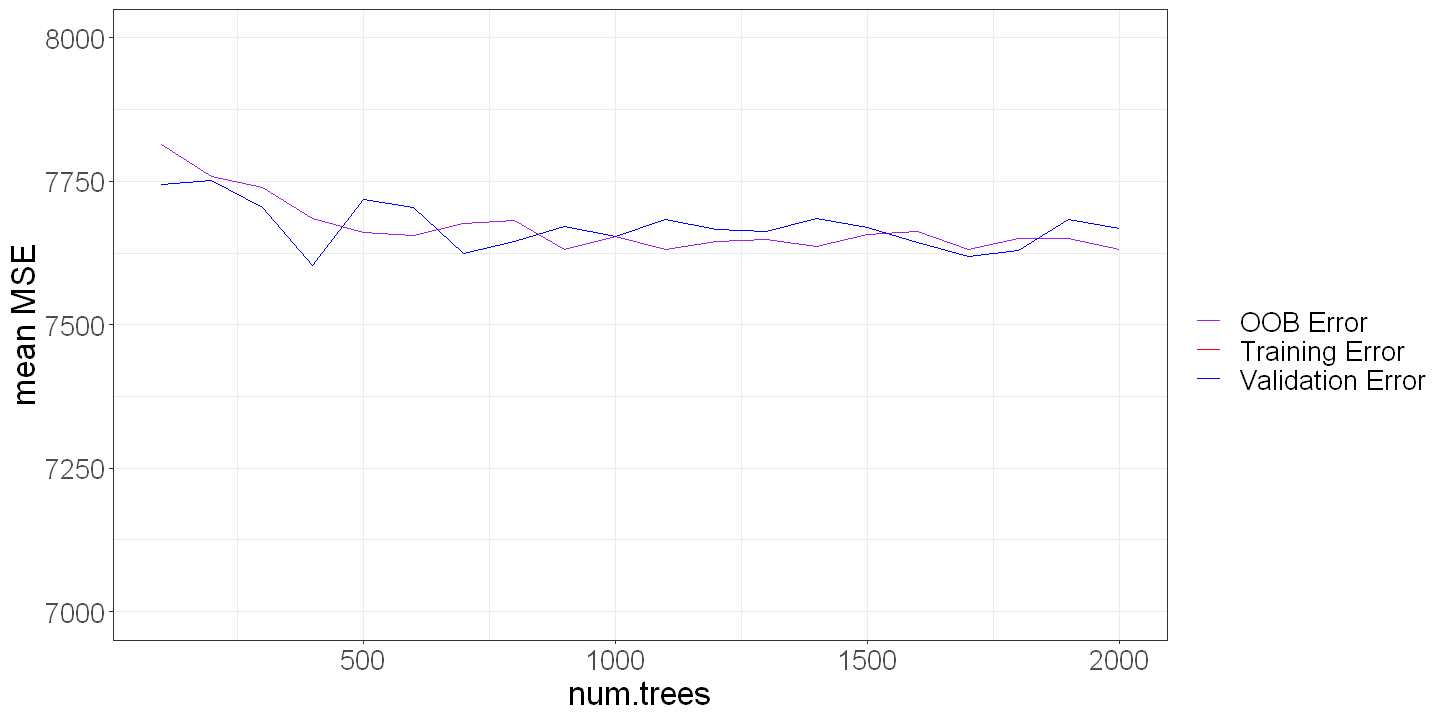

In [118]:
p +
ylim(c(7000,8000))

The trend is again a bit hard to see. They all seem to have similar MSE, with a slight decline from the lower end (0~500 trees). I tried using greater numbers of `num.trees` but my computer couldn't handle it. Also, the MSE around high ~7500 seems to be pretty comparable to other models we fitted, so I don't imagine it would go that much lower if we used a lot more trees. Now, storing the top 3 `num.trees` values to fit the test model:

In [121]:
candidate_num.trees <- wildfires_bagging_reg_num.trees_meanerr %>%
    arrange(mean_val_err) %>%
    head(3) %>%
    select(num.trees)
t(as.matrix(candidate_num.trees))

num.trees,400,1700,700


### 2. Testing Candidate Models<a class="anchor" id="3c2"></a>
Again there are 3 models to fit

In [122]:
(wildfires_bagging_reg <- tibble(
  train = wildfires_train %>% list(), # model building set
  test = wildfires_test %>% list() # original test set
  ) %>%
  crossing(num.trees = candidate_num.trees$num.trees) %>% # crossing 3 num.trees
  mutate(
    model = map2(.x = train, .y = num.trees, 
                 .f = function(x, y) ranger(burned ~ . - wlf, 
                                            mtry = 15, # using all predictors
                                            num.trees = y,
                                            data = x, 
                                            splitrule = "variance", 
                                            importance = "impurity")), 
    # Get training, test, and OOB error
    train_err = map2_dbl(model, train, mse_ranger, outcome = "burned"), 
    test_err = map2_dbl(model, test, mse_ranger, outcome = "burned"), 
    oob_err = map_dbl(.x = model, 
                      .f = function(x) x[["prediction.error"]])
  ) %>%
  arrange(test_err) %>% # arranging by lowest to highest test MSE
  select(num.trees, train_err, test_err, oob_err)) # selecing relevant columns

num.trees,train_err,test_err,oob_err
<dbl>,<dbl>,<dbl>,<dbl>
1700,1292.128,9329.011,7632.853
700,1291.471,9405.534,7630.147
400,1292.177,9456.982,7775.027


Storing the model that performed the best to compare with other models


In [124]:
# Storing best performing model
(wildfires_reg_models <- wildfires_bagging_reg %>%
  select(test_err) %>%
  head(1) %>%
  mutate(model_type = "Bagging", tuning = "num.trees = 700") %>%
  rename(testMSE = test_err) %>%
  select(model_type, tuning, testMSE) %>%
  rbind(wildfires_reg_models))

model_type,tuning,testMSE
<chr>,<chr>,<dbl>
Bagging,num.trees = 700,9329.011
Random Forest,mtry = 8,9459.360
XGBoost,"eta = 0.07209327, nrounds = 100",11264.495


### 3. Additional Analysis <a class="anchor" id="3c3"></a>

#### Variable Importance and Partial Dependence

Again, I will see if there is any difference between the variable importance that Random Forest determined, and bagging method's variable importance, using the best `num.trees` value. I expect them to be similar. 


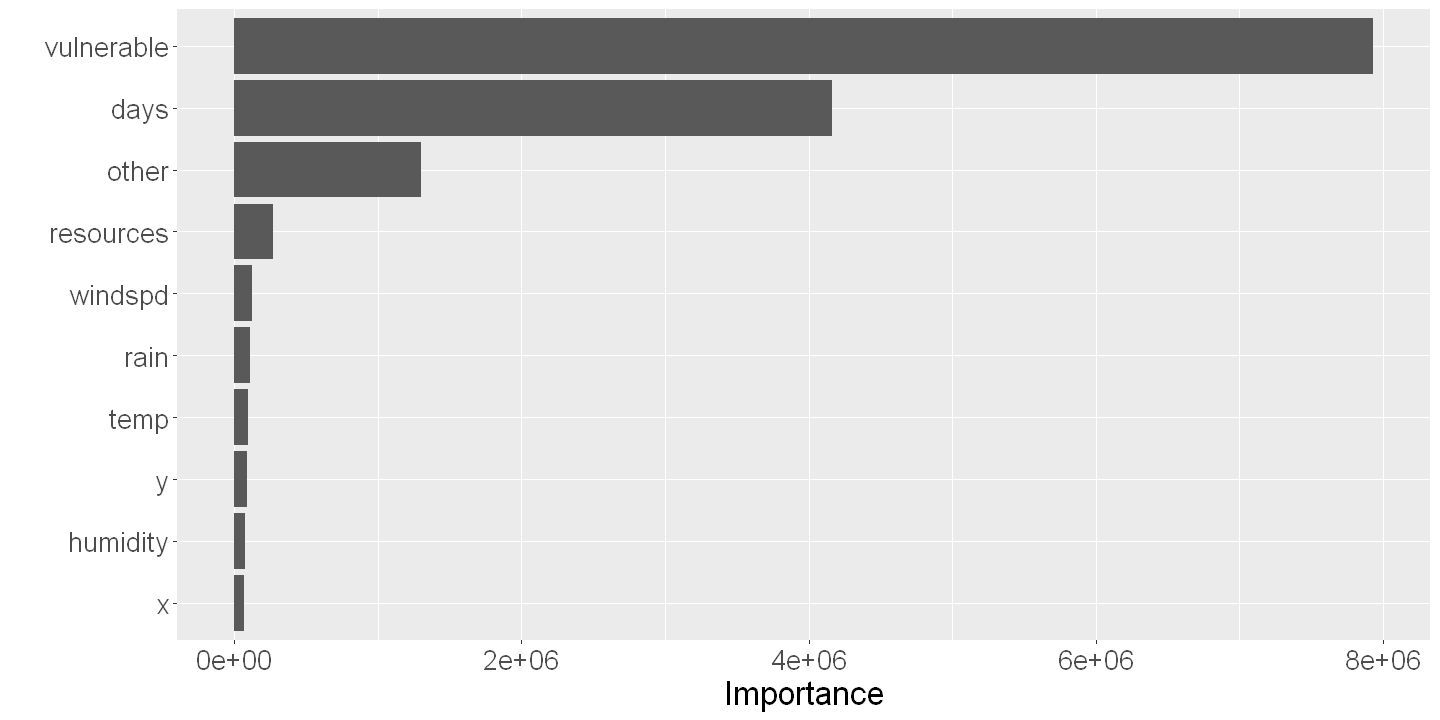

In [126]:
wildfires_bagging_reg_num.trees700 <- ranger(burned ~ . - wlf, 
                                      data = wildfires_test, 
                                      mtry = 15,
                                      num.trees = 700,
                                      importance = "impurity", 
                                      splitrule = "variance")

vip(wildfires_bagging_reg_num.trees700) +
    theme(text=element_text(size=20))

It seems like the graph is quite similar, with `vulnerable`, `days`, and `other` being the most important predictors. Doing the same for partial dependence:

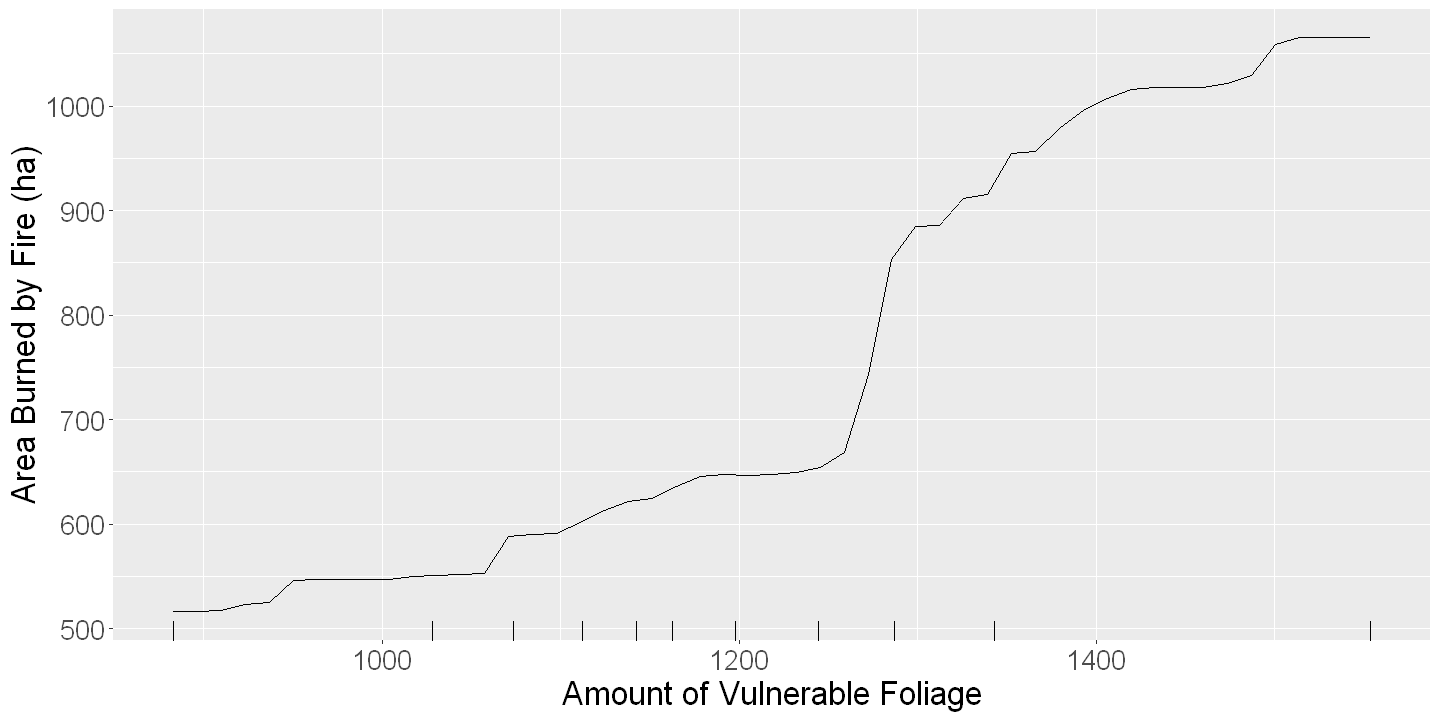

In [127]:
partial(wildfires_bagging_reg_num.trees700, 
        pred.var = "vulnerable",
        pred.data = wildfires_test,
        plot = TRUE,
        rug = TRUE,
        plot.engine = "ggplot2") + 
  labs(y = "Area Burned by Fire (ha)", x = "Amount of Vulnerable Foliage") +
    theme(text=element_text(size=20))

***

## D. Linear Regression<a class="anchor" id="3d"></a>

### 1. Defining Models/Cross Validation <a class="anchor" id="3d1"></a>

Because there's not really a tuning parameter I can adjust in unregularized linear regression, based on the variable importance plots above, I selected ten different models we can fit.

In [128]:
model_def <- tibble(modelNo = c("mod01", "mod02", "mod03", "mod04", "mod05",
                               "mod06", "mod07", "mod08", "mod09", "mod10"), 
                    fmla = c("burned ~ . - wlf",
                             "burned ~ vulnerable",
                             "burned ~ vulnerable + days",
                             "burned ~ vulnerable + days + other",
                             "burned ~ vulnerable + days + other + resources",
                             "burned ~ vulnerable + days + other + resources + windspd",
                             "burned ~ . - wlf - vulnerable",
                             "burned ~ poly(vulnerable, 2)",
                             "burned ~ days + other + resources",
                             "burned ~ vulnerable + days + resources"))
model_def

modelNo,fmla
<chr>,<chr>
mod01,burned ~ . - wlf
mod02,burned ~ vulnerable
mod03,burned ~ vulnerable + days
mod04,burned ~ vulnerable + days + other
mod05,burned ~ vulnerable + days + other + resources
mod06,burned ~ vulnerable + days + other + resources + windspd
mod07,burned ~ . - wlf - vulnerable
mod08,"burned ~ poly(vulnerable, 2)"
mod09,burned ~ days + other + resources


Above are the ten different combinations of features to use in the linear regression model. 
- In `mod01` I use all variables except for the target variable for classification tasks, `wlf`. 
- In `mod07` I use all variables except for the target variable for classification tasks, `wlf`, and `vulnerable`. 
- In `mod08`, polynomial regression is applied for the `vulnerable` feature. 
I fit these ten models and observe their test MSE via 10-fold CV.


In [130]:
wildfires_lm_reg_models <- wildfires_train %>% 
  crossv_kfold(10, id = "folds") %>%
  crossing(model_def) %>% # trying 10 different models
  mutate(
    train = map(train, as_tibble),
    test = map(test, as_tibble),
    # Fit models for each formula
    model_fit = map2(fmla, train, lm), 
    train_mse = map2_dbl(model_fit, train, mse), 
    test_mse = map2_dbl(model_fit, test, mse)
  )

# Calculating Mean MSE's
(wildfires_lm_reg_models_meanmse <- wildfires_lm_reg_models %>%
    group_by(modelNo, fmla) %>%
    summarise(mean_train_mse = mean(train_mse),
              mean_val_mse = mean(test_mse)) %>%
    arrange(mean_val_mse))

`summarise()` has grouped output by 'modelNo'. You can override using the `.groups` argument.



modelNo,fmla,mean_train_mse,mean_val_mse
<chr>,<chr>,<dbl>,<dbl>
mod01,burned ~ . - wlf,5220.392,6064.953
mod06,burned ~ vulnerable + days + other + resources + windspd,5829.327,6126.542
mod05,burned ~ vulnerable + days + other + resources,5919.327,6193.430
mod04,burned ~ vulnerable + days + other,6140.959,6368.966
mod07,burned ~ . - wlf - vulnerable,5540.555,6481.481
mod09,burned ~ days + other + resources,6747.311,6987.144
mod10,burned ~ vulnerable + days + resources,7315.756,7648.552
mod03,burned ~ vulnerable + days,10723.265,11112.014
mod08,"burned ~ poly(vulnerable, 2)",11862.637,12210.186


Using all features resulted in the lowest CV MSE, and using other selected significant variables (according to the random forest feature importance test) resulted in similarly low MSEs. Using only the `vulnerable` feature (`mod02`) performed the poorest, as even if it's the most important feature, much more information is needed for an accurate prediction. Generally, it seems that the more features are used, the lower the MSE. 

I will now store the best 3 linear regression models to fit onto the test data, just like I've been doing before.


In [132]:
(candidate_lm <- wildfires_lm_reg_models_meanmse %>%
    arrange(mean_val_mse) %>%
    head(3) %>%
    select(modelNo, fmla))

modelNo,fmla
<chr>,<chr>
mod01,burned ~ . - wlf
mod06,burned ~ vulnerable + days + other + resources + windspd
mod05,burned ~ vulnerable + days + other + resources


### 2. Testing Candidate Models <a class="anchor" id="3d2"></a>

Making predictions for the above 3 candidate linear regression models onto the test set and calculating the respective MSEs:


In [133]:
# Fit Candidate Models
(wildfires_lm_reg <- tibble(
  train = wildfires_train %>% list(),
  test = wildfires_test %>% list()
  ) %>%
  crossing(candidate_lm) %>%
  mutate(
    # Fit models for each formula
    model_fit = map2(fmla, train, lm), 
    train_mse = map2_dbl(model_fit, train, mse), # train MSE
    test_mse = map2_dbl(model_fit, test, mse) # test MSE
  ) %>%
  arrange(test_mse) %>% # order from lowest to highest test MSE
  select(modelNo, fmla, train_mse, test_mse)) # select relevant columns

modelNo,fmla,train_mse,test_mse
<chr>,<chr>,<dbl>,<dbl>
mod06,burned ~ vulnerable + days + other + resources + windspd,5844.006,6919.794
mod01,burned ~ . - wlf,5261.223,6949.955
mod05,burned ~ vulnerable + days + other + resources,5932.904,7266.638


Storing the Best Model to Compare to Other Models


In [134]:
(wildfires_reg_models <- wildfires_lm_reg %>%
  select(test_mse) %>%
  head(1) %>%
  mutate(model_type = "Linear", tuning = "fmla = burned ~ vulnerable + days + other + resources + windspd") %>%
  rename(testMSE = test_mse) %>%
  select(model_type, tuning, testMSE) %>%
  rbind(wildfires_reg_models))

model_type,tuning,testMSE
<chr>,<chr>,<dbl>
Linear,fmla = burned ~ vulnerable + days + other + resources + windspd,6919.794
Bagging,num.trees = 700,9329.011
Random Forest,mtry = 8,9459.360
XGBoost,"eta = 0.07209327, nrounds = 100",11264.495


So far, linear regression is performing far better than the other models. 

***

## E. Regularized Linear Regression (Ridge)<a class="anchor" id="3e"></a>

### 1. Defining Models/Cross Validation<a class="anchor" id="3e1"></a>

Lastly, I will fit Ridge Regression. The tuning parameter I will be observing is $\lambda$ (`lambda`), the regularization parameter. The $\lambda$ that minimizes MSE, and the $\lambda$ that is within 1 SE of the minimum $\lambda$, will be both used in the models to fit the test set.

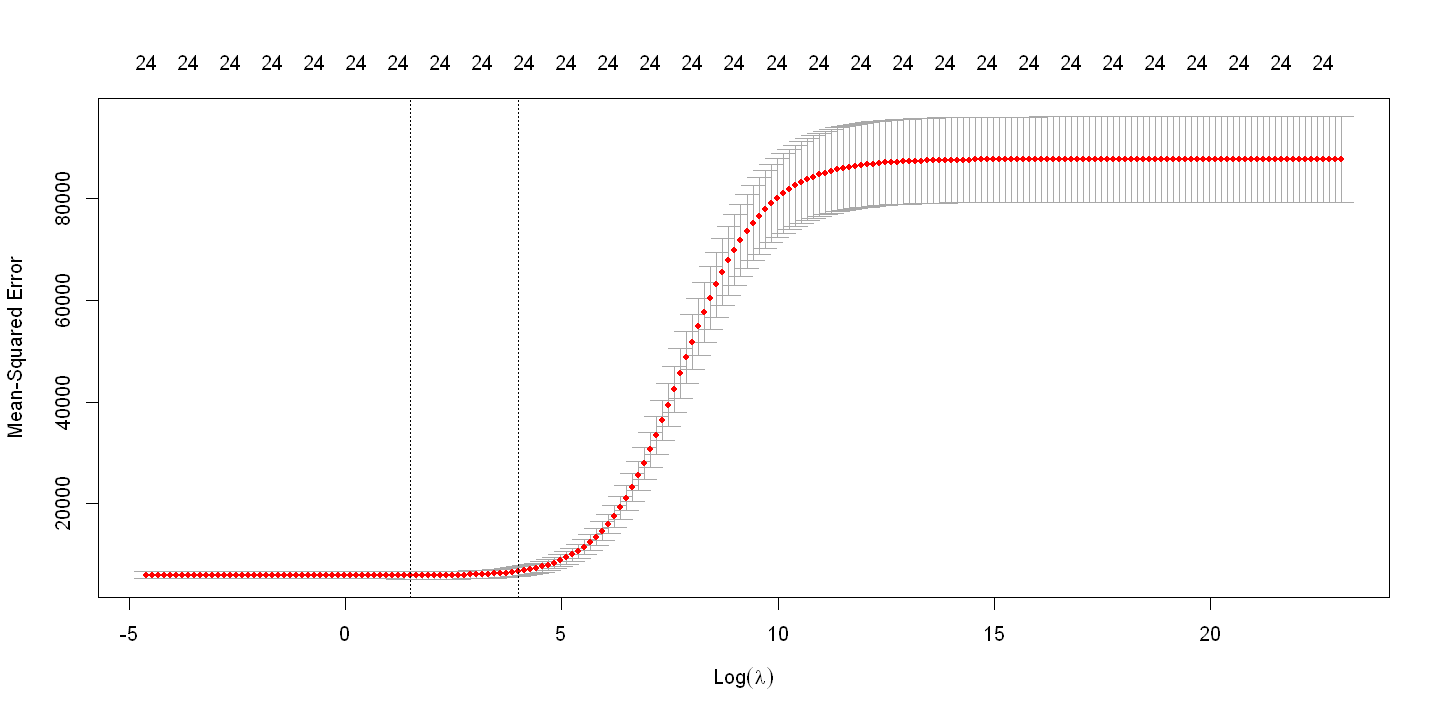

In [137]:
# Setting up 200 possible lambda values 
lambda_grid <- 10^seq(-2, 10, length = 200)

# Performing 10 fold cross validation 
wildfires_ridge_reg_cv <- wildfires_train %>% 
  cv.glmnet(
    formula = burned ~ . - wlf, 
    data = ., 
    alpha = 0, 
    nfolds = 10,
    lambda = lambda_grid
  )

# Plotting lambda vs. MSE
plot(wildfires_ridge_reg_cv) 

The two lambda values I will be using for the candidate models

In [138]:
lambda_min <- wildfires_ridge_reg_cv$lambda.min # minimum lambda
lambda_1se <- wildfires_ridge_reg_cv$lambda.1se # 1 SE lambda

(lambdas <- tibble(lambda = c(lambda_min, lambda_1se))) # values

lambda
<dbl>
4.500558
54.789012


The $\lambda$ that minimizes Cross Validation MSE is 4.5. Lambda that outputs a MSE that is one standard error above the minimum MSE is 54.789. The latter value is larger and introduces more bias to the model, but still close enough to the minimum to still output a small MSE. 

### 2. Testing Candidate Models <a class="anchor" id="3e2"></a>

Similarly as above, we will add the two candidate models onto the Test Set and calculate the Test MSE.

In [139]:
(wildfires_ridge_reg <- tibble(
  train = wildfires_train %>% list(),
  test  = wildfires_test %>% list()
  ) %>%
  mutate(
    ridge_min = map(train, ~ glmnet(burned ~ . - wlf, data = .x,
                                    alpha = 0, lambda = lambda_min)), # model 1
    ridge_1se = map(train, ~ glmnet(burned ~ . - wlf, data = .x,
                                    alpha = 0, lambda = lambda_1se)) # model 2
  ) %>% 
  pivot_longer(cols = c(-test, -train), names_to = "method", values_to = "fit") %>% # reformatting
  mutate(pred = map2(fit, test, predict),
         test_mse = map2_dbl(test, pred, ~ mean((.x$burned - .y)^2))) %>% # calculating test MSE
  arrange(test_mse) %>% # Arranging from lowest to highest test MSE
  select(method, test_mse) %>% # selecting relevant columns
  cbind(lambdas) %>% # adding lambda value info to the tibble to each model
  select(method, lambda, test_mse)) # reordering

method,lambda,test_mse
<chr>,<dbl>,<dbl>
ridge_min,4.500558,6988.295
ridge_1se,54.789012,7736.007


We can see that the model with the lambda that minimizes the MSE in the test set of the model building set `wildfires_train` has the lowest MSE when fit onto the original test set. Storing information for comparison:


In [145]:
# Storing for Comparison
wildfires_reg_models <- wildfires_ridge_reg %>%
  select(test_mse) %>%
  head(1) %>%
  mutate(model_type = "Ridge", tuning = "lambda = 2.97") %>%
  rename(testMSE = test_mse) %>%
  select(model_type, tuning, testMSE) %>%
  rbind(wildfires_reg_models)

# Summary of All Models
wildfires_reg_models %>%
  arrange(testMSE)

model_type,tuning,testMSE
<chr>,<chr>,<dbl>
Linear,fmla = burned ~ vulnerable + days + other + resources + windspd,6919.794
Ridge,lambda = 2.97,6988.295
Bagging,num.trees = 700,9329.011
Random Forest,mtry = 8,9459.360
XGBoost,"eta = 0.07209327, nrounds = 100",11264.495


***

# IV. Conclusion<a class="anchor" id="4"></a>

Above is a summary of all models and how they performed on the test set. Linear regression models seem to do a better job than the decision tree-based methods. As complicated it was, tuning two different parameters, XGBoost performed the worst, not too far behind Bagging and Random Forest.

Ensemble Tree-based methods are generally more powerful and have a higher tendency to overfit. Observing their training errors, Bagging and Random Forest models had around ~1000 MSE while XGBoost was very close to zero. It is clear that I was severely overfitting the model and may need to adjust the range of hyperparameters. To introduce more bias to the models, I can
- Decrease the learning rate of XGBoost/increase number of trees
    - Decreasing the learning rate in gradient boosting means more iterations of sequential trees, which can introduce more bias but requires greater computational power. Similarly to increasing `num_trees` in random forest or bagging; increasing the number of trees in the ensemble means introducing more randomness to the model, means more bias. 
    - There seems to be a local minimum in the MSE in the learning rate value we tested for XGboost, but smaller values can be used to see if there is a better global minimum, using greater computational power
        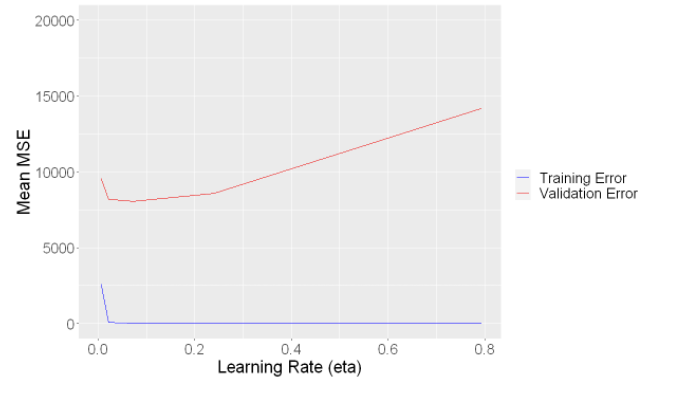
    - There seems to be a very slight gradual decline with the increase of `num_trees`. We can increase this hyperparameter even more to see if the MSE reaches a global minimum.
        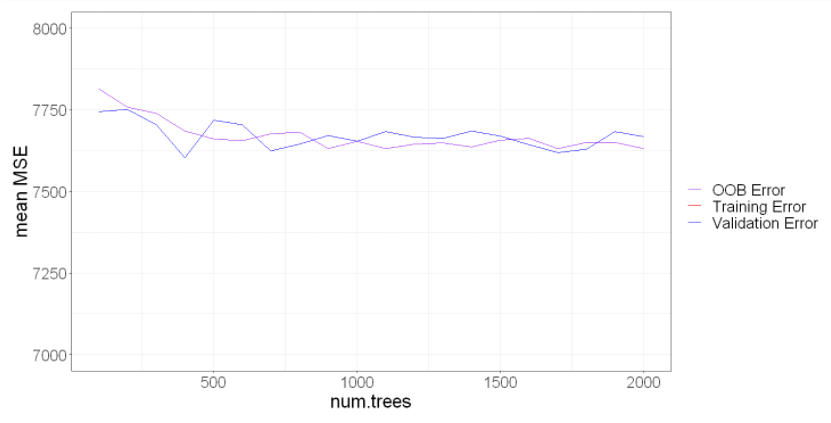
- Control Tree Depth
    - I haven't touched the hyperparameters that deal with tree depth. Reducing depth of trees introduces more bias and will be worth looking into if we are dealing with tree models that overfit. 
- Feature Engineering
    - With the exception of the random forest model, the tree-based model used all 15 predictors. Manually selecting out certain features (or based on variable importance tests), or conducting dimensionality reduction by PCA to combine some correlated features might be helpful 
